# ---------------------- Imports ----------------------

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary
import onnx
import onnxruntime as ort
from sklearn.metrics import precision_score, recall_score, f1_score
from glob import glob

# ---------------------- Dataset Class ----------------------

In [39]:
class SaliencyDatasetLateFusion(Dataset):
    def __init__(self, rgb_paths, ir_paths, mask_paths, transform_image=None, transform_mask=None):
        self.rgb_paths = rgb_paths
        self.ir_paths = ir_paths
        self.mask_paths = mask_paths
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        rgb_image = Image.open(self.rgb_paths[idx]).convert("RGB")
        ir_image = Image.open(self.ir_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform_image:
            rgb_image = self.transform_image(rgb_image)
            ir_image = self.transform_image(ir_image)

        if self.transform_mask:
            mask = self.transform_mask(mask)

        return rgb_image, ir_image, mask

# ---------------- Datasets and DataLoaders ----------------

In [40]:
rgb_dirs = [
    r"/home/user/Shivam/dsr_project/dataset/Co-registered/Simulated dataset/images/RGB",
    r"/home/user/Shivam/dsr_project/dataset/Co-registered/us mil Paper dataset/images/RGB"
]

ir_dirs = [
    r"/home/user/Shivam/dsr_project/dataset/Co-registered/Simulated dataset/images/norm_ir_8bit",
    r"/home/user/Shivam/dsr_project/dataset/Co-registered/us mil Paper dataset/images/IR_norm8bit"
]

mask_dirs = [
    r"/home/user/Shivam/dsr_project/dataset/Co-registered/Simulated dataset/saliency_masks",
    r"/home/user/Shivam/dsr_project/dataset/Co-registered/us mil Paper dataset/Saliency_map/RGB"
]

# Helper to gather and sort all paths
def collect_image_paths(dirs):
    paths = []
    for d in dirs:
        paths.extend(glob(os.path.join(d, "*.png")))
        paths.extend(glob(os.path.join(d, "*.jpg")))
        paths.extend(glob(os.path.join(d, "*.jpeg")))
    return sorted(paths)

rgb_paths = collect_image_paths(rgb_dirs)
ir_paths = collect_image_paths(ir_dirs)
mask_paths = collect_image_paths(mask_dirs)

assert len(rgb_paths) == len(ir_paths) == len(mask_paths), "Mismatch in dataset lengths"


In [41]:
train_rgb, test_rgb, train_ir, test_ir, train_masks, test_masks = train_test_split(
    rgb_paths, ir_paths, mask_paths, test_size=0.2, random_state=42
)

transform_image = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = SaliencyDatasetLateFusion(train_rgb, train_ir, train_masks, transform_image, transform_mask)
test_dataset = SaliencyDatasetLateFusion(test_rgb, test_ir, test_masks, transform_image, transform_mask)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ---------------------- Model Definition --------------------

In [3]:
class Saliency_LateFusion(nn.Module):
    def __init__(self):
        super(Saliency_LateFusion, self).__init__()

        # RGB Encoder
        self.rgb_encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )

        # IR Encoder
        self.ir_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )

        # Fusion + Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=1), nn.Sigmoid()
        )

    def forward(self, rgb, ir):
        rgb_feat = self.rgb_encoder(rgb)
        ir_feat = self.ir_encoder(ir)
        fused = torch.cat([rgb_feat, ir_feat], dim=1)
        out = self.decoder(fused)
        return out


# ---------------------- Training Setup ----------------------

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_LateFusion().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------- Training Loop ----------------------

In [44]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for rgb, ir, masks in train_loader:
        rgb, ir, masks = rgb.to(device), ir.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(rgb, ir)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")


Epoch [1/100], Loss: 0.2091
Epoch [2/100], Loss: 0.1502
Epoch [3/100], Loss: 0.1378
Epoch [4/100], Loss: 0.1323
Epoch [5/100], Loss: 0.1312
Epoch [6/100], Loss: 0.1254
Epoch [7/100], Loss: 0.1205
Epoch [8/100], Loss: 0.1178
Epoch [9/100], Loss: 0.1150
Epoch [10/100], Loss: 0.1133
Epoch [11/100], Loss: 0.1115
Epoch [12/100], Loss: 0.1068
Epoch [13/100], Loss: 0.1065
Epoch [14/100], Loss: 0.1013
Epoch [15/100], Loss: 0.0999
Epoch [16/100], Loss: 0.0988
Epoch [17/100], Loss: 0.0967
Epoch [18/100], Loss: 0.0947
Epoch [19/100], Loss: 0.0939
Epoch [20/100], Loss: 0.0935
Epoch [21/100], Loss: 0.0922
Epoch [22/100], Loss: 0.0880
Epoch [23/100], Loss: 0.0875
Epoch [24/100], Loss: 0.0861
Epoch [25/100], Loss: 0.0862
Epoch [26/100], Loss: 0.0854
Epoch [27/100], Loss: 0.0831
Epoch [28/100], Loss: 0.0830
Epoch [29/100], Loss: 0.0810
Epoch [30/100], Loss: 0.0814
Epoch [31/100], Loss: 0.0793
Epoch [32/100], Loss: 0.0785
Epoch [33/100], Loss: 0.0795
Epoch [34/100], Loss: 0.0829
Epoch [35/100], Loss: 0

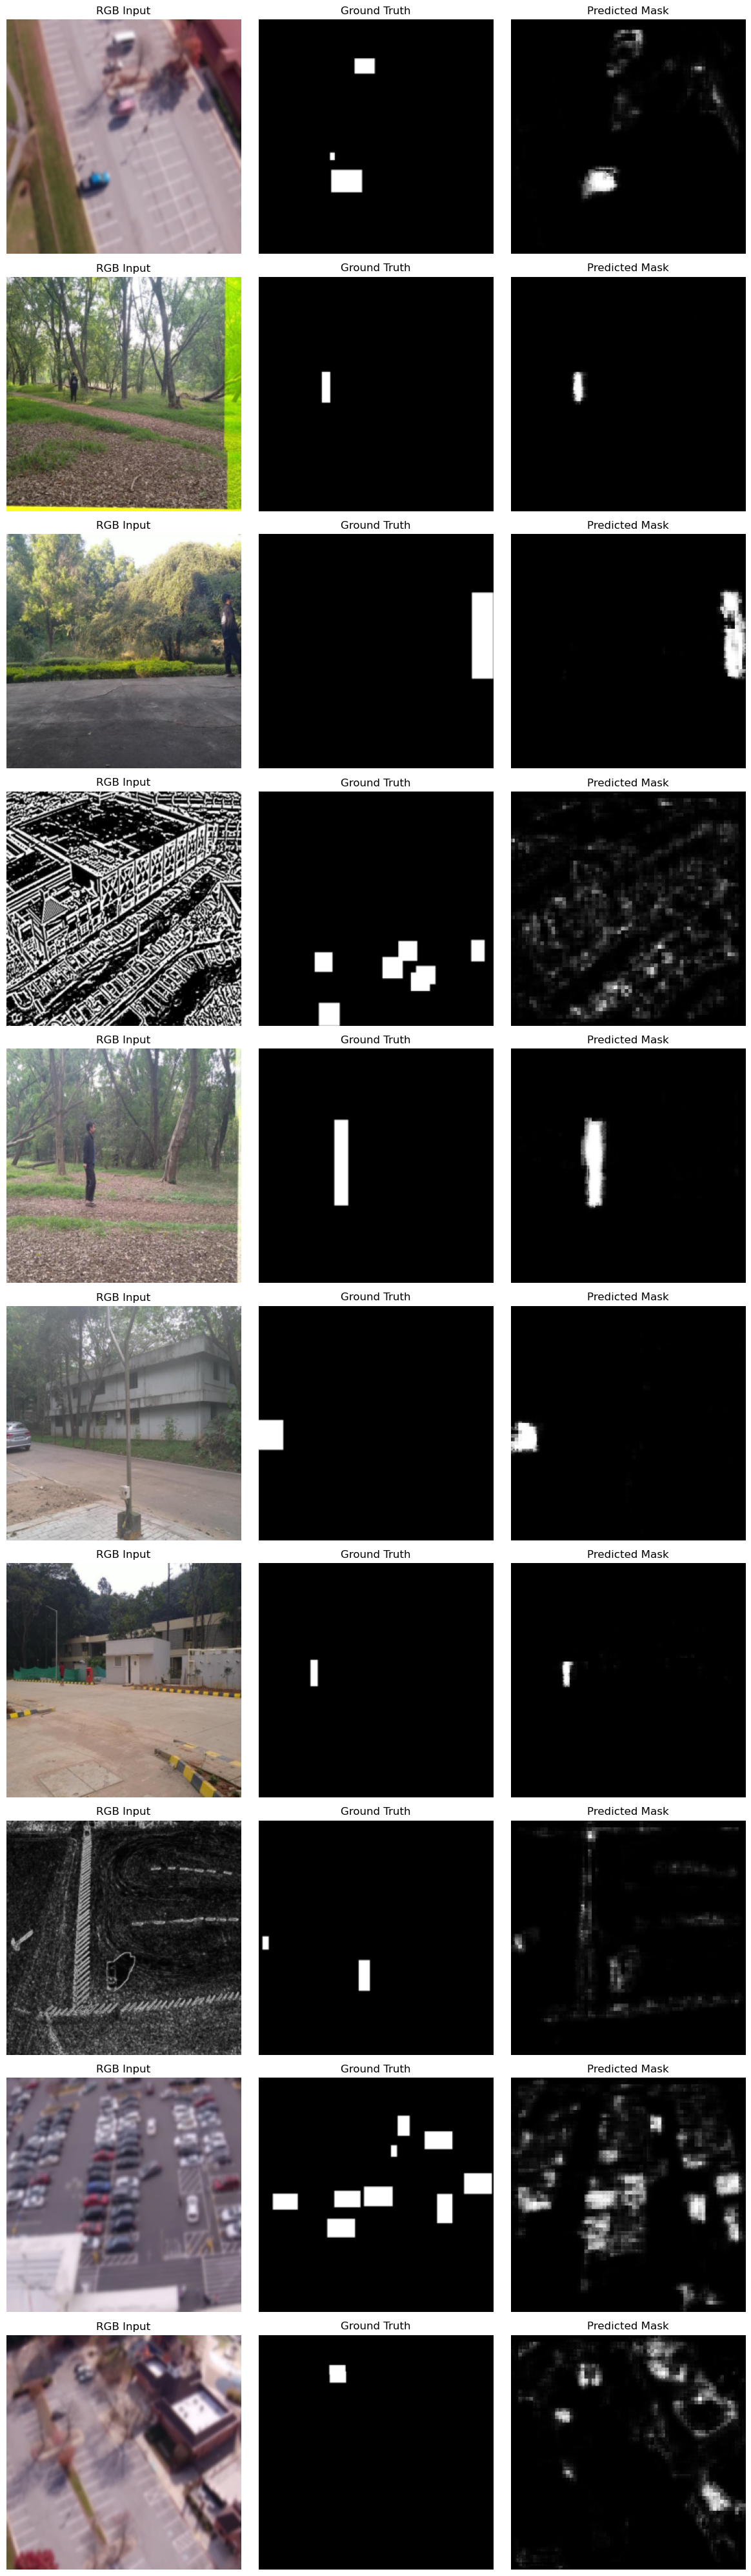

In [45]:
model.eval()
with torch.no_grad():
    fig, axes = plt.subplots(10, 3, figsize=(12, 40))
    for idx in range(10):
        rgb, ir, mask = test_dataset[idx]
        rgb = rgb.unsqueeze(0).to(device)
        ir = ir.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0).to(device)

        output = model(rgb, ir)

        rgb_np = rgb[0].permute(1, 2, 0).cpu().numpy()
        mask_np = mask[0][0].cpu().numpy()
        output_np = output[0][0].cpu().numpy()

        axes[idx, 0].imshow(rgb_np)
        axes[idx, 0].set_title("RGB Input")
        axes[idx, 0].axis("off")

        axes[idx, 1].imshow(mask_np, cmap='gray')
        axes[idx, 1].set_title("Ground Truth")
        axes[idx, 1].axis("off")

        axes[idx, 2].imshow(output_np, cmap='gray')
        axes[idx, 2].set_title("Predicted Mask")
        axes[idx, 2].axis("off")

    plt.tight_layout()
    plt.show()

# ---------------------- Save Model ----------------------

In [46]:
torch.save(model.state_dict(), "/home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_late_fusion.pth")
print("Model saved as saliency_model_late_fusion.pth")

Model saved as saliency_model_late_fusion.pth


In [47]:
# Instantiate model and load weights
model = Saliency_LateFusion().to(device)
model.load_state_dict(torch.load("/home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_late_fusion.pth"))
model.eval()

/tmp/ipykernel_54145/1055700844.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/user/Shivam/dsr_project/Project_files/models/sali

Saliency_LateFusion(
  (rgb_encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ir_encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): Conv

In [48]:
# ---------------------- Model Summary ---------------------
summary(model, input_size=[(3, 256, 256), (1, 256, 256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
              ReLU-5         [-1, 64, 128, 128]               0
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7         [-1, 32, 256, 256]             320
              ReLU-8         [-1, 32, 256, 256]               0
         MaxPool2d-9         [-1, 32, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]          18,496
             ReLU-11         [-1, 64, 128, 128]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]         147,584
             ReLU-14          [-1, 128,

In [49]:
# ------------------ Export Model to ONNX ------------------
dummy_rgb = torch.randn(1, 3, 256, 256).to(device)
dummy_ir = torch.randn(1, 1, 256, 256).to(device)

onnx_export_path = "/home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_late_fusion.onnx"

torch.onnx.export(
    model, (dummy_rgb, dummy_ir), onnx_export_path,
    input_names=["rgb_input", "ir_input"],
    output_names=["output"],
    opset_version=11,
    do_constant_folding=True
)

print(f"Model exported successfully to {onnx_export_path}")

# ------------------- Verify ONNX Model -------------------
onnx_model = onnx.load(onnx_export_path)
onnx.checker.check_model(onnx_model)
print("ONNX model is valid!")

ort_session = ort.InferenceSession(onnx_export_path)
dummy_rgb_np = np.random.randn(1, 3, 256, 256).astype(np.float32)
dummy_ir_np = np.random.randn(1, 1, 256, 256).astype(np.float32)

ort_inputs = {
    ort_session.get_inputs()[0].name: dummy_rgb_np,
    ort_session.get_inputs()[1].name: dummy_ir_np,
}
ort_outs = ort_session.run(None, ort_inputs)

print(f"ONNX Inference output shape: {ort_outs[0].shape}")

Model exported successfully to /home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_late_fusion.onnx
ONNX model is valid!
ONNX Inference output shape: (1, 1, 256, 256)


# ------------ Metrics and application example ------------

In [50]:
def compute_iou(pred_mask, true_mask, threshold=0.5):
    pred_bin = (pred_mask > threshold).astype(np.uint8)
    true_bin = (true_mask > 0.5).astype(np.uint8)
    intersection = np.logical_and(pred_bin, true_bin).sum()
    union = np.logical_or(pred_bin, true_bin).sum()
    if union == 0:
        return float(intersection == 0)
    return intersection / union

In [51]:
ious = []
model.eval()
with torch.no_grad():
    for rgb, ir, masks in test_loader:
        rgb, ir, masks = rgb.to(device), ir.to(device), masks.to(device)
        outputs = model(rgb, ir)
        for i in range(outputs.size(0)):
            pred = outputs[i][0].cpu().numpy()
            true = masks[i][0].cpu().numpy()
            iou = compute_iou(pred, true)
            ious.append(iou)

mean_iou = np.mean(ious)
print(f"Mean IoU on test set: {mean_iou:.4f}")

Mean IoU on test set: 0.5312


In [52]:
def compute_min_salient_fraction(dataloader):
    min_fraction = float('inf')
    valid_count = 0
    for _, _, masks in dataloader:
        for mask in masks:
            binary_mask = (mask[0].numpy() > 0.5).astype(np.uint8)
            if np.sum(binary_mask) == 0:
                continue
            frac = np.sum(binary_mask) / binary_mask.size
            min_fraction = min(min_fraction, frac)
            valid_count += 1
    if valid_count == 0:
        raise ValueError("No non-empty masks found.")
    return min_fraction

threshold_fraction = compute_min_salient_fraction(test_loader)
print(f"Data-driven Saliency Threshold: {threshold_fraction:.4f}")

def is_object_present(saliency_map, threshold=0.5, pixel_fraction=0.001):
    return (np.sum(saliency_map > threshold) / saliency_map.size) > pixel_fraction

Data-driven Saliency Threshold: 0.0010


In [53]:
# Recall for saliency-based object detection
y_true, y_pred = [], []
with torch.no_grad():
    for rgb, ir, masks in test_loader:
        rgb, ir, masks = rgb.to(device), ir.to(device), masks.to(device)
        outputs = model(rgb, ir)
        for i in range(rgb.size(0)):
            pred = outputs[i][0].cpu().numpy()
            true = masks[i][0].cpu().numpy()
            y_true.append(is_object_present(true, 0.5, 0.001))
            y_pred.append(is_object_present(pred, 0.5, 0.001))

recall = sum(t and p for t, p in zip(y_true, y_pred)) / (sum(y_true) + 1e-6)
print(f"Object Presence Recall: {recall:.4f}")

Object Presence Recall: 0.8966


In [54]:
y_true, y_pred = [], []

with torch.no_grad():
    for rgb, ir, masks in test_loader:
        rgb, ir, masks = rgb.to(device), ir.to(device), masks.to(device)
        outputs = model(rgb, ir)
        pred = outputs[0][0].cpu().numpy()
        true = masks[0][0].cpu().numpy()

        pred_frac = np.sum(pred > 0.5) / pred.size
        true_frac = np.sum(true > 0.5) / true.size

        y_true.append(true_frac > threshold_fraction)
        y_pred.append(pred_frac > threshold_fraction)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


Precision: 0.9901
Recall:    0.8621
F1-score:  0.9217


Predicted: Object Present
Ground Truth: Object Present


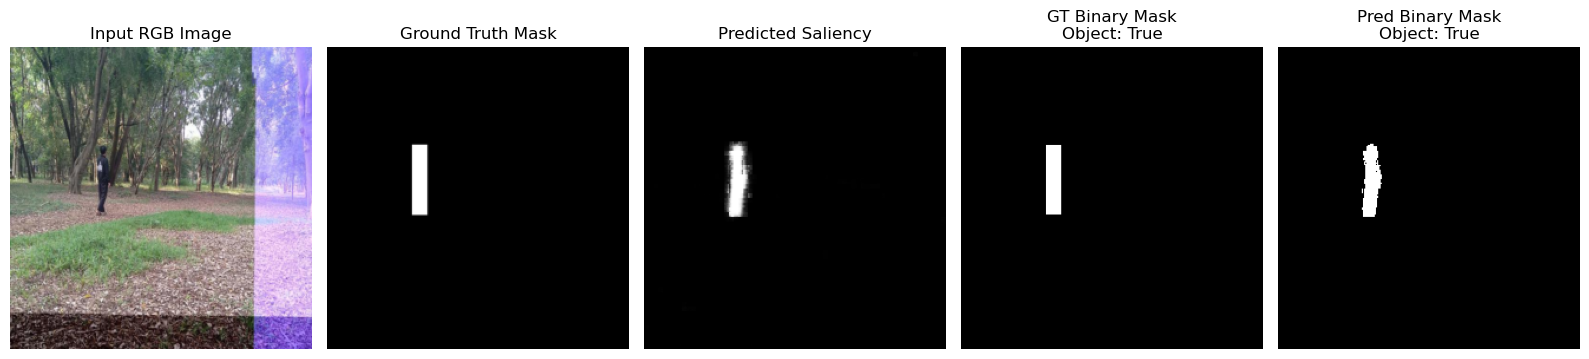

Predicted: Object Present
Ground Truth: Object Present


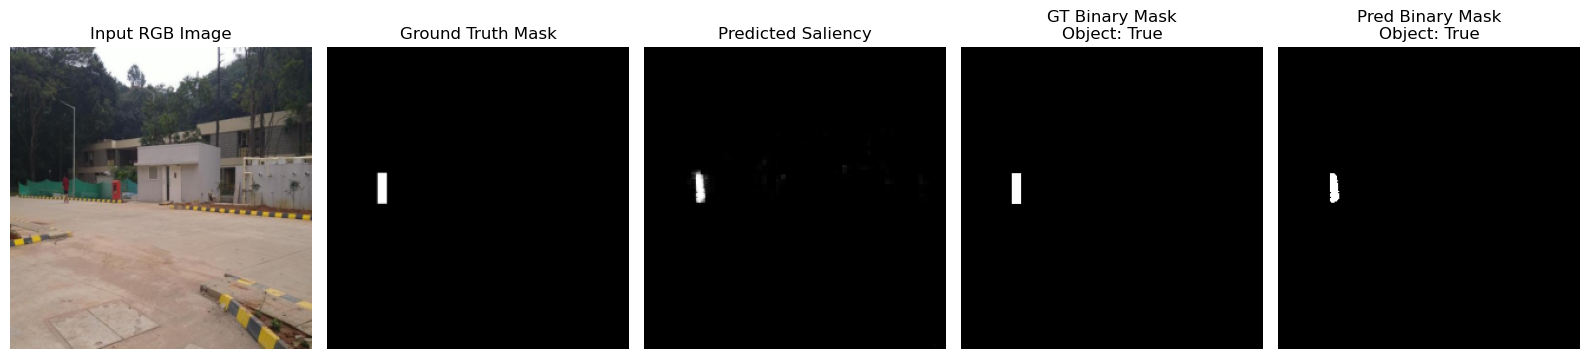

Predicted: No Object
Ground Truth: No Object


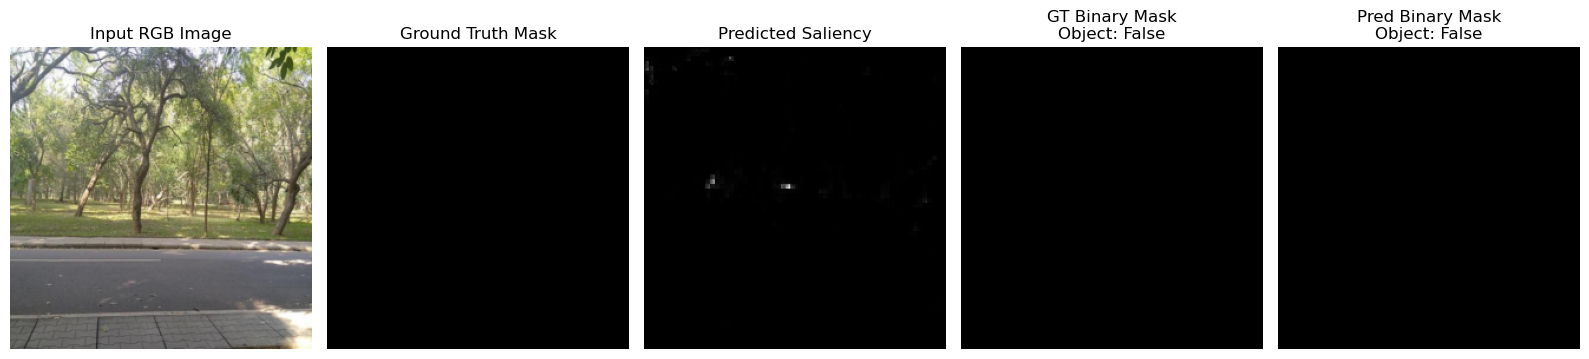

Predicted: No Object
Ground Truth: Object Present


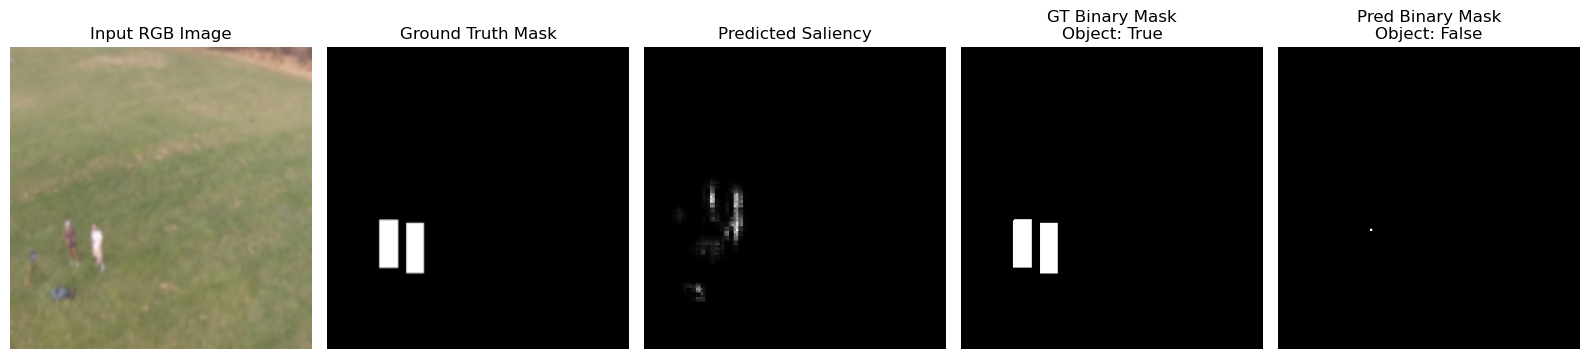

Predicted: Object Present
Ground Truth: Object Present


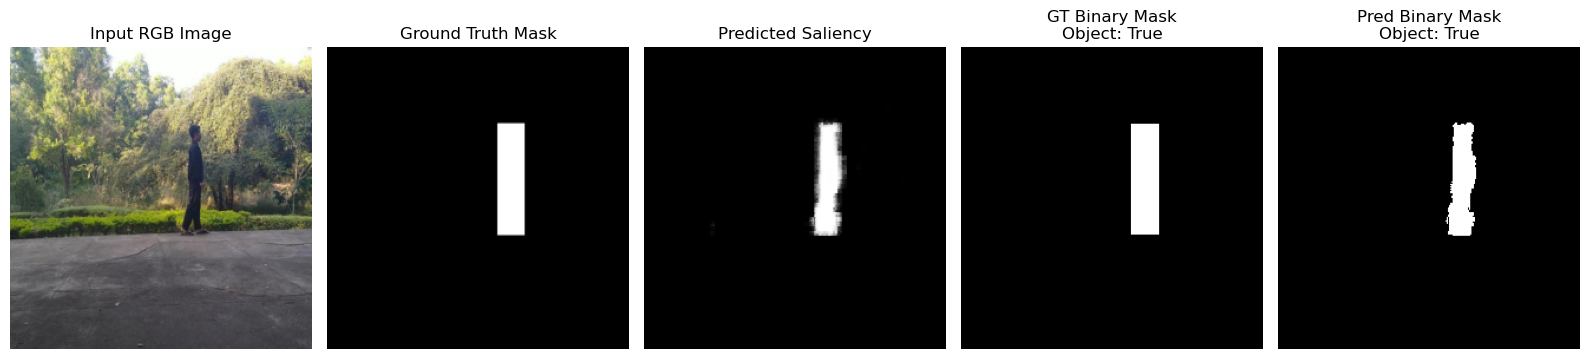

Predicted: Object Present
Ground Truth: Object Present


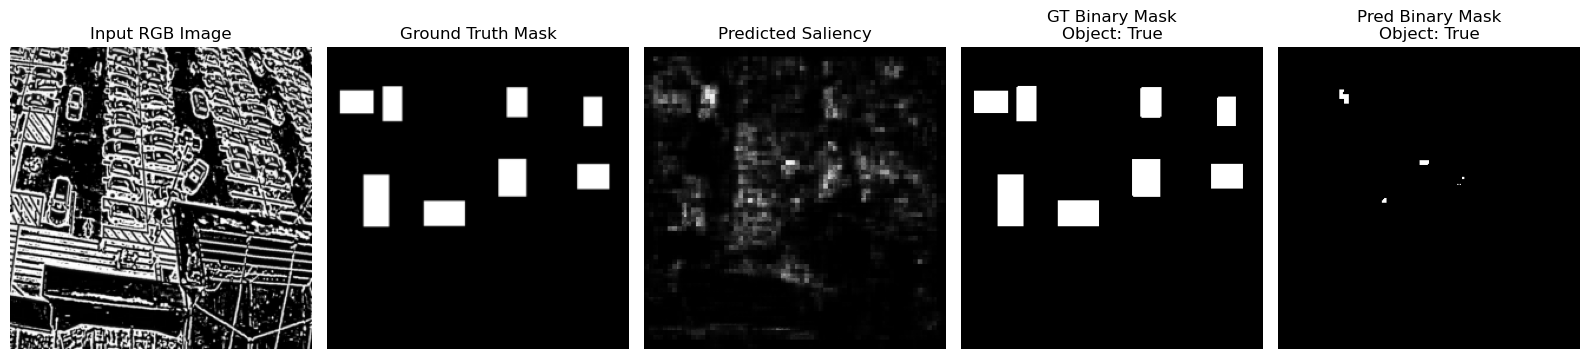

Predicted: Object Present
Ground Truth: Object Present


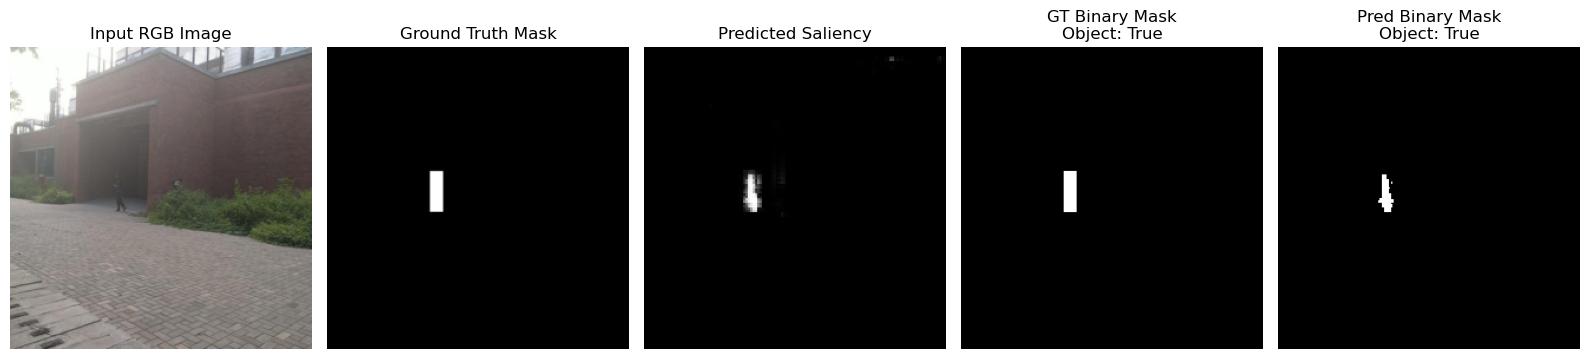

Predicted: No Object
Ground Truth: Object Present


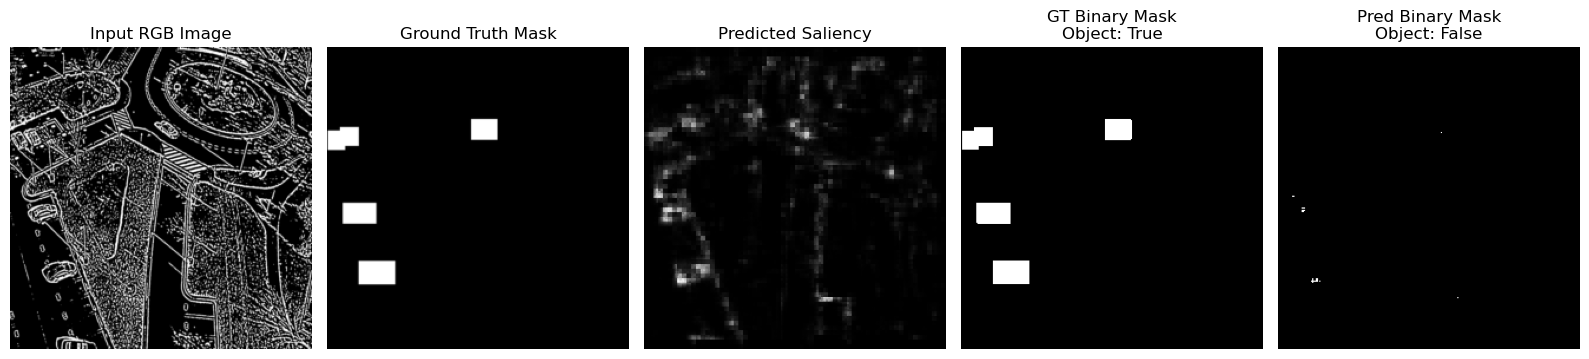

Predicted: Object Present
Ground Truth: Object Present


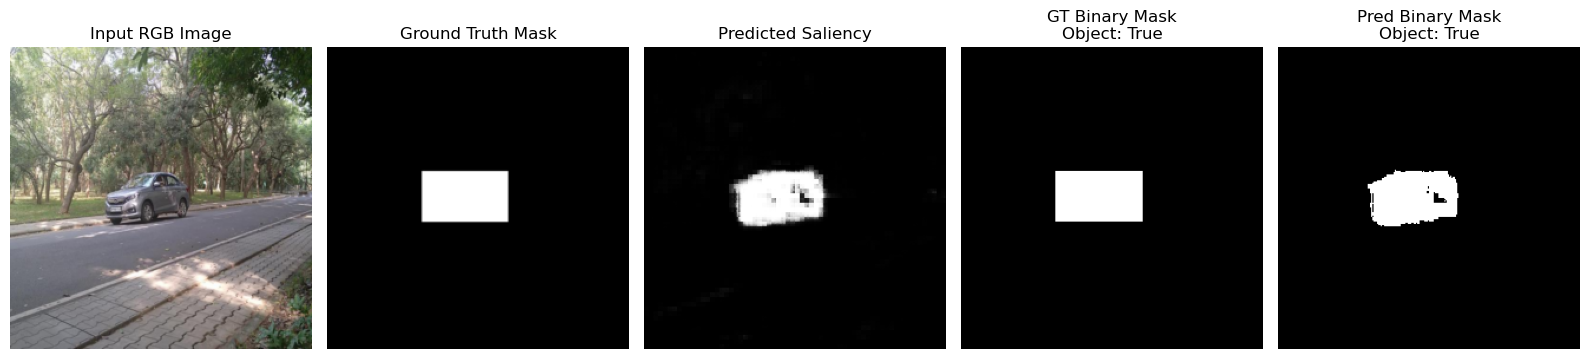

Predicted: Object Present
Ground Truth: Object Present


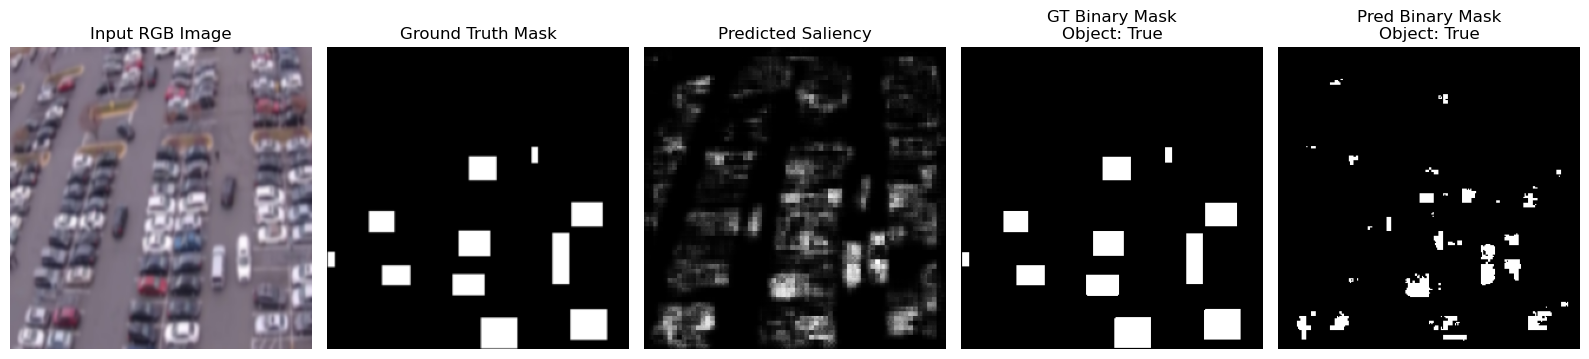

In [55]:
def visualize_detection_logic(model, dataloader, threshold=0.5, area_fraction=0.001, num_samples=10):
    model.eval()
    with torch.no_grad():
        indices = random.sample(range(len(dataloader.dataset)), num_samples)
        for idx in indices:
            rgb, ir, mask = dataloader.dataset[idx]
            rgb = rgb.unsqueeze(0).to(device)
            ir = ir.unsqueeze(0).to(device)
            mask = mask.unsqueeze(0).to(device)

            output = model(rgb, ir)
            pred = output[0][0].cpu().numpy()
            gt = mask[0][0].cpu().numpy()
            rgb_np = rgb[0].cpu().permute(1, 2, 0).numpy()

            pred_bin = pred > threshold
            gt_bin = gt > threshold
            pred_present = (np.sum(pred_bin) / pred_bin.size) > area_fraction
            gt_present = (np.sum(gt_bin) / gt_bin.size) > area_fraction

            print(f"Predicted: {'Object Present' if pred_present else 'No Object'}")
            print(f"Ground Truth: {'Object Present' if gt_present else 'No Object'}")

            fig, axs = plt.subplots(1, 5, figsize=(16, 4))
            axs[0].imshow(rgb_np)
            axs[0].set_title("Input RGB Image")
            axs[1].imshow(gt, cmap="gray")
            axs[1].set_title("Ground Truth Mask")
            axs[2].imshow(pred, cmap="gray")
            axs[2].set_title("Predicted Saliency")
            axs[3].imshow(gt_bin, cmap="gray")
            axs[3].set_title(f"GT Binary Mask\nObject: {gt_present}")
            axs[4].imshow(pred_bin, cmap="gray")
            axs[4].set_title(f"Pred Binary Mask\nObject: {pred_present}")

            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.show()

visualize_detection_logic(model, test_loader, threshold=0.5, area_fraction=0.001, num_samples=10)

# ------------------ Export Model to .PT ------------------

In [4]:
# Instantiate model and load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_LateFusion().to(device)
model.load_state_dict(torch.load("/home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_late_fusion.pth"))
model.eval()

/tmp/ipykernel_342209/797276767.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/user/Shivam/dsr_project/Project_files/models/sali

Saliency_LateFusion(
  (rgb_encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ir_encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): Conv

In [5]:
model = model.to('cpu')

In [8]:
dummy_rgb = torch.randn(1, 3, 256, 256)  # for the RGB branch
dummy_ir  = torch.randn(1, 1, 256, 256)  # for the IR branch
# Trace the model to TorchScript
traced_model = torch.jit.trace(model, (dummy_rgb, dummy_ir))

In [10]:
# Save the TorchScript model
output_path = "/home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_late_fusion.pt"
traced_model.save(output_path)

print(f"TorchScript model saved to {output_path}")

TorchScript model saved to /home/user/Shivam/dsr_project/Project_files/models/saliency/saliency_model_late_fusion.pt
